In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score
import warnings
warnings.filterwarnings('ignore')

df = pd.read_csv('../data/koi_cumulative.csv', comment='#')
print(f"Dataset shape: {df.shape}")
print(df[['koi_steff', 'koi_slogg', 'koi_srad', 'koi_kepmag']].describe().round(2))

Dataset shape: (9564, 49)
       koi_steff  koi_slogg  koi_srad  koi_kepmag
count    9201.00    9201.00   9201.00     9563.00
mean     5706.82       4.31      1.73       14.26
std       796.86       0.43      6.13        1.39
min      2661.00       0.05      0.11        6.97
25%      5310.00       4.22      0.83       13.44
50%      5767.00       4.44      1.00       14.52
75%      6112.00       4.54      1.34       15.32
max     15896.00       5.36    229.91       20.00


## Program 3: K-Means Clustering — Stellar Classification

**Scientific Background:**  
Stars are naturally classified into spectral types (F, G, K, M) based on their
surface temperature, surface gravity, and radius. These properties are physically
linked through stellar evolution theory.

We apply **K-Means clustering** to group Kepler host stars using their measured
stellar parameters — without telling the algorithm what the groups should be.
The hypothesis is that the clusters will naturally recover known stellar classes.

**Features:** Stellar effective temperature, surface gravity, stellar radius, Kepler magnitude  
**Goal:** Discover natural groupings and interpret them astrophysically

In [2]:
# Stellar features for clustering
features = ['koi_steff', 'koi_slogg', 'koi_srad', 'koi_kepmag']
labels_col = 'koi_disposition'

data = df[features + [labels_col]].dropna()
print(f"Usable rows: {len(data)}")

X = data[features].values

# Scale
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

Usable rows: 9200


In [3]:
# Find optimal k using Elbow Method + Silhouette Score
inertias = []
silhouettes = []
K_range = range(2, 11)

for k in K_range:
    km = KMeans(n_clusters=k, random_state=42, n_init=10)
    km.fit(X_scaled)
    inertias.append(km.inertia_)
    silhouettes.append(silhouette_score(X_scaled, km.labels_))
    print(f"k={k}: Inertia={km.inertia_:.1f}, Silhouette={silhouette_score(X_scaled, km.labels_):.4f}")

best_k = K_range[np.argmax(silhouettes)]
print(f"\nBest k by silhouette score: {best_k}")

k=2: Inertia=26699.5, Silhouette=0.4131
k=3: Inertia=18494.9, Silhouette=0.4061
k=4: Inertia=14651.5, Silhouette=0.3982
k=5: Inertia=11938.2, Silhouette=0.3519
k=6: Inertia=10176.7, Silhouette=0.3515
k=7: Inertia=9117.6, Silhouette=0.3061
k=8: Inertia=8068.9, Silhouette=0.3071
k=9: Inertia=7338.3, Silhouette=0.3135
k=10: Inertia=6616.2, Silhouette=0.2969

Best k by silhouette score: 2


In [4]:
# Fit final KMeans with best_k
kmeans = KMeans(n_clusters=best_k, random_state=42, n_init=10)
cluster_labels = kmeans.fit_predict(X_scaled)
data = data.copy()
data['cluster'] = cluster_labels

print(f"Cluster distribution:")
print(data['cluster'].value_counts().sort_index())

# PCA for 2D visualization
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)
data['pca1'] = X_pca[:, 0]
data['pca2'] = X_pca[:, 1]

print(f"\nPCA explained variance: {pca.explained_variance_ratio_*100}")
print(f"Total variance captured: {sum(pca.explained_variance_ratio_)*100:.1f}%")

# Cluster centers (original scale)
centers_original = scaler.inverse_transform(kmeans.cluster_centers_)
centers_df = pd.DataFrame(centers_original, columns=features)
centers_df.index.name = 'Cluster'
print(f"\nCluster Centers (original scale):")
print(centers_df.round(2))

Cluster distribution:
cluster
0    2871
1    6329
Name: count, dtype: int64

PCA explained variance: [48.10626633 30.70017788]
Total variance captured: 78.8%

Cluster Centers (original scale):
         koi_steff  koi_slogg  koi_srad  koi_kepmag
Cluster                                            
0          6138.88       3.92      3.53       12.75
1          5511.61       4.49      0.91       14.96


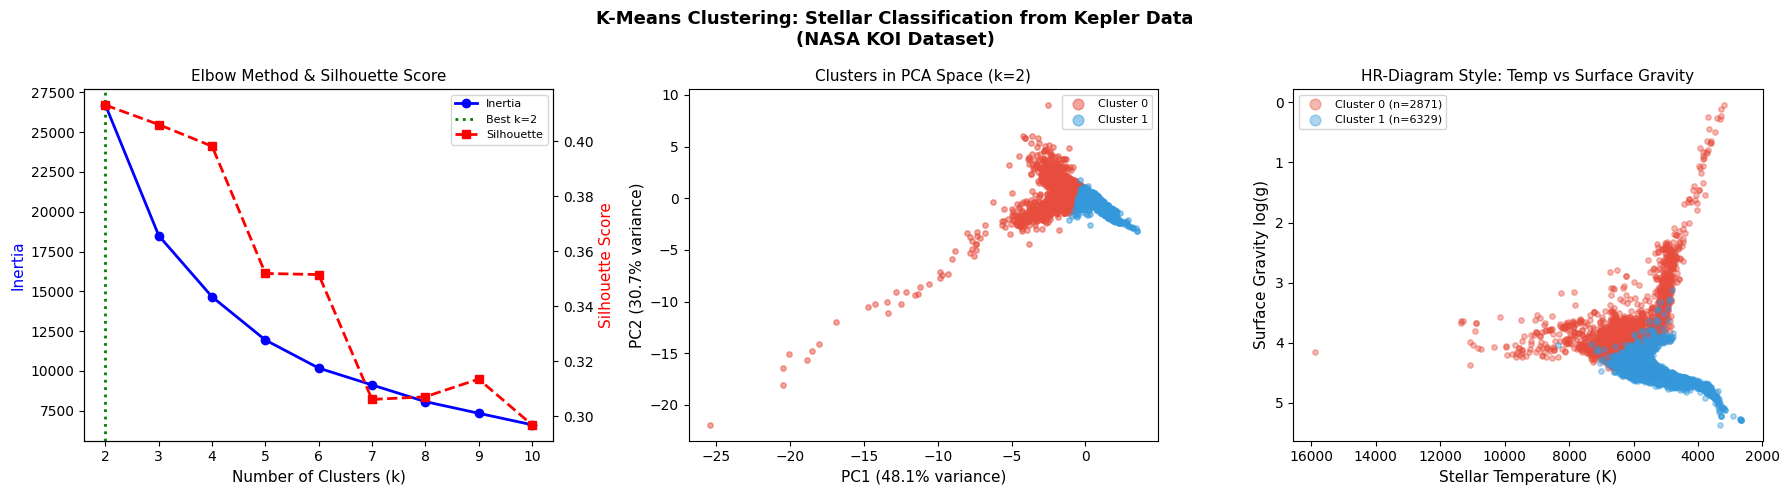

Plot saved!


In [5]:
colors = ['#e74c3c', '#3498db', '#2ecc71', '#f39c12', '#9b59b6',
          '#1abc9c', '#e67e22', '#e91e63', '#00bcd4']

fig, axes = plt.subplots(1, 3, figsize=(18, 5))
fig.suptitle('K-Means Clustering: Stellar Classification from Kepler Data\n(NASA KOI Dataset)',
             fontsize=13, fontweight='bold')

# Plot 1: Elbow + Silhouette
ax1 = axes[0]
ax1_twin = ax1.twinx()
ax1.plot(list(K_range), inertias, 'bo-', lw=2, markersize=6, label='Inertia')
ax1_twin.plot(list(K_range), silhouettes, 'rs--', lw=2, markersize=6, label='Silhouette')
ax1.axvline(best_k, color='green', linestyle=':', lw=2, label=f'Best k={best_k}')
ax1.set_xlabel('Number of Clusters (k)', fontsize=11)
ax1.set_ylabel('Inertia', color='blue', fontsize=11)
ax1_twin.set_ylabel('Silhouette Score', color='red', fontsize=11)
ax1.set_title('Elbow Method & Silhouette Score', fontsize=11)
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax1_twin.get_legend_handles_labels()
ax1.legend(lines1 + lines2, labels1 + labels2, loc='upper right', fontsize=8)

# Plot 2: PCA Scatter of Clusters
for i in range(best_k):
    mask = data['cluster'] == i
    axes[1].scatter(data.loc[mask, 'pca1'], data.loc[mask, 'pca2'],
                   c=colors[i], alpha=0.5, s=15, label=f'Cluster {i}')
axes[1].set_xlabel(f'PC1 ({pca.explained_variance_ratio_[0]*100:.1f}% variance)', fontsize=11)
axes[1].set_ylabel(f'PC2 ({pca.explained_variance_ratio_[1]*100:.1f}% variance)', fontsize=11)
axes[1].set_title(f'Clusters in PCA Space (k={best_k})', fontsize=11)
axes[1].legend(markerscale=2, fontsize=8)

# Plot 3: Temperature vs Surface Gravity (Hertzsprung-Russell style)
for i in range(best_k):
    mask = data['cluster'] == i
    n = mask.sum()
    axes[2].scatter(data.loc[mask, 'koi_steff'], data.loc[mask, 'koi_slogg'],
                   c=colors[i], alpha=0.4, s=15, label=f'Cluster {i} (n={n})')
axes[2].invert_xaxis()  # Hotter stars on left (astronomical convention)
axes[2].invert_yaxis()  # Higher gravity at bottom
axes[2].set_xlabel('Stellar Temperature (K)', fontsize=11)
axes[2].set_ylabel('Surface Gravity log(g)', fontsize=11)
axes[2].set_title('HR-Diagram Style: Temp vs Surface Gravity', fontsize=11)
axes[2].legend(markerscale=2, fontsize=8)

plt.tight_layout()
plt.savefig('../outputs/plots/03_kmeans_clustering.png', dpi=150, bbox_inches='tight')
plt.show()
print("Plot saved!")

In [6]:
print("Astrophysical Interpretation of Clusters")
print("=" * 55)

stellar_types = {
    'F-type': 'Teff > 6000K, moderate gravity — slightly hotter than Sun',
    'G-type': 'Teff 5200-6000K — Sun-like stars',
    'K-type': 'Teff 3900-5200K — cooler orange dwarfs',
    'M-type': 'Teff < 3900K — cool red dwarfs, most common in galaxy',
    'Subgiant': 'Low log(g), evolving off main sequence'
}

for i, row in centers_df.iterrows():
    teff = row['koi_steff']
    logg = row['koi_slogg']
    srad = row['koi_srad']
    n = (data['cluster'] == i).sum()

    if teff > 6000:
        stype = 'F-type (hot)'
    elif teff > 5200:
        stype = 'G-type (Sun-like)'
    elif teff > 3900:
        stype = 'K-type (orange dwarf)'
    else:
        stype = 'M-type (red dwarf)'

    if logg < 4.0:
        stype += ' / Subgiant'

    print(f"\nCluster {i} ({n} stars) → likely {stype}")
    print(f"  Teff={teff:.0f}K  log(g)={logg:.2f}  R={srad:.2f}R☉")

print(f"""
Key insight: K-Means recovered stellar spectral classes
WITHOUT being told what those classes are — purely from
photometric and spectroscopic parameters in Kepler data.
This validates the physical meaningfulness of our features.
""")

Astrophysical Interpretation of Clusters

Cluster 0 (2871 stars) → likely F-type (hot) / Subgiant
  Teff=6139K  log(g)=3.92  R=3.53R☉

Cluster 1 (6329 stars) → likely G-type (Sun-like)
  Teff=5512K  log(g)=4.49  R=0.91R☉

Key insight: K-Means recovered stellar spectral classes
WITHOUT being told what those classes are — purely from
photometric and spectroscopic parameters in Kepler data.
This validates the physical meaningfulness of our features.

